<a href="https://colab.research.google.com/github/GopikaPavithran/Prodigy-Internship/blob/main/Prodigy_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [ ]:
from google.colab import files
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import warnings
from keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
warnings.filterwarnings('ignore')

# Dataset Loading

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:16<00:00, 181MB/s]
100% 2.13G/2.13G [00:16<00:00, 136MB/s]


In [ ]:
!unzip leapgestrecog.zip

# Category Analysis

In [ ]:
data = '//content/leapgestrecog/leapGestRecog'
new_data= '//content/leapgestrecog/selected_images'
os.makedirs(new_data,exist_ok=True)
main_directories = os.listdir(data)
categories = set()
for main_dir in main_directories:
    main_dir_path = os.path.join(data, main_dir)
    if os.path.isdir(main_dir_path):
        subdirectories = [name for name in os.listdir(main_dir_path) if os.path.isdir(os.path.join(main_dir_path, name))]
        for sub_dir in subdirectories:
            sub_dir_path = os.path.join(main_dir_path, sub_dir)
            image_files = [f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))]
            selected_images = random.sample(image_files, min(10, len(image_files)))
            new_sub_dir_path = os.path.join(new_data, sub_dir)
            os.makedirs(new_sub_dir_path, exist_ok=True)
            for image in selected_images:
                original_image_path = os.path.join(sub_dir_path, image)
                new_image_path = os.path.join(new_sub_dir_path, image)
                shutil.copy(original_image_path, new_image_path)
print("Selected images have been copied to:", new_data)

Selected images have been copied to: //content/leapgestrecog/selected_images


In [ ]:
data='//content/leapgestrecog/selected_images'
categories = set()
dirs = os.listdir(data)
for dir in dirs:
  dir=[name[3:] for name in os.listdir(data)]
  categories.update(dir)
categories = list(categories)
print("Categories:", categories)

Categories: ['palm_moved', 'fist', 'palm', 'ok', 'index', 'fist_moved', 'thumb', 'l', 'c', 'down']


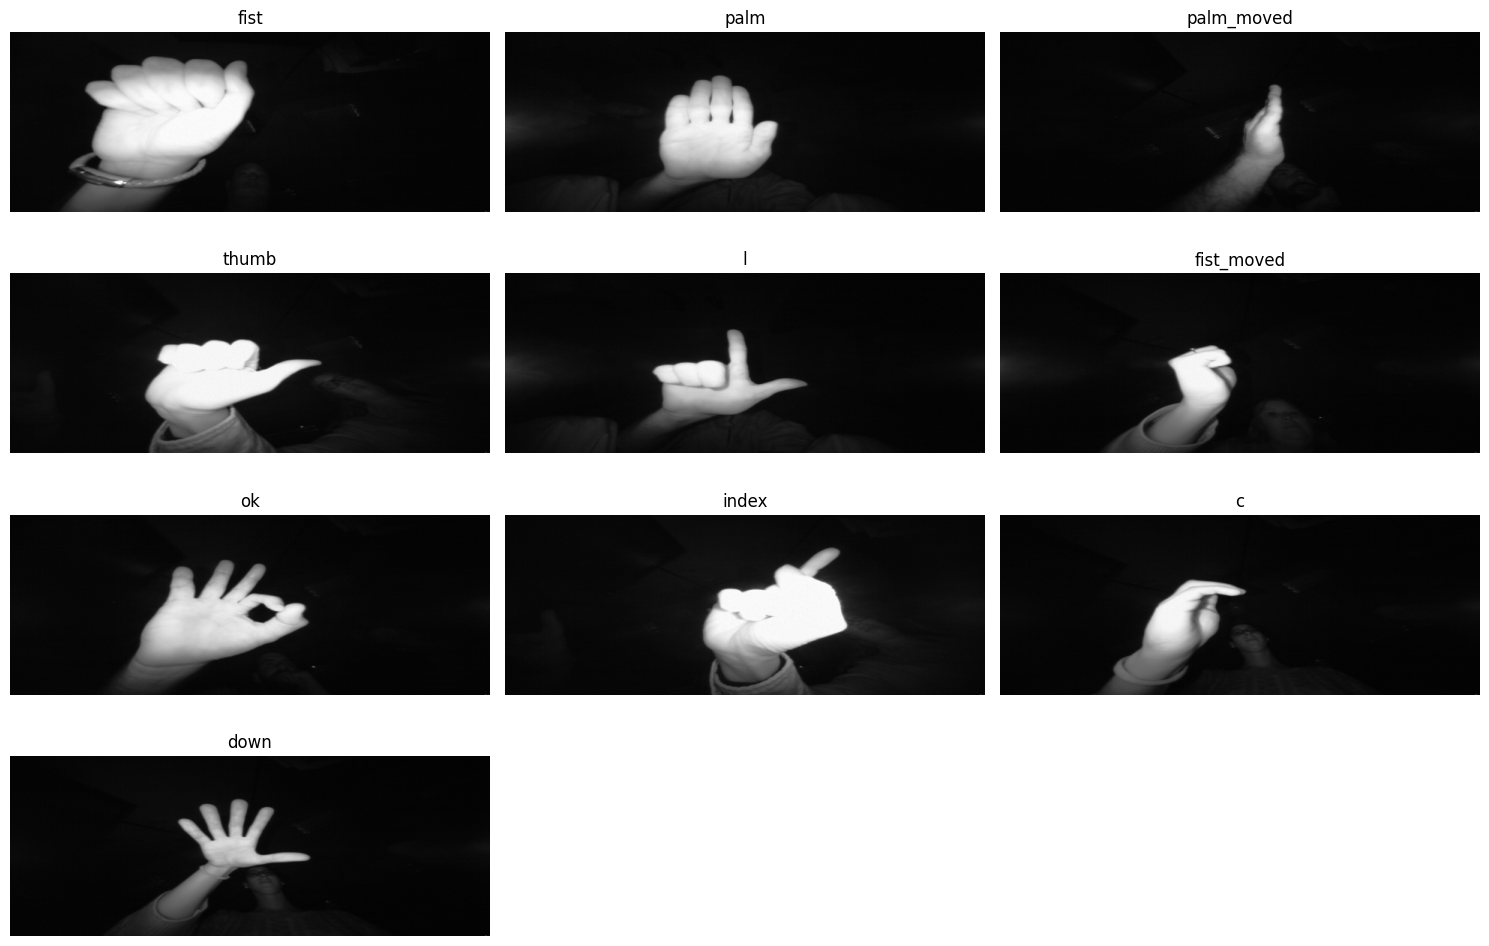

In [ ]:
sub_dirs = [name for name in os.listdir(new_data) if os.path.isdir(os.path.join(new_data, name))]
cols = 3
rows = (len(sub_dirs) // cols) + (len(sub_dirs) % cols > 0)
plt.figure(figsize=(15, 10))
for idx, sub_dir in enumerate(sub_dirs):
    sub_dir_path = os.path.join(new_data, sub_dir)
    image_files = [f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))]
    if image_files:
        image_path = os.path.join(sub_dir_path,image_files[0])
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        category_name = sub_dir[3:]
        plt.title(category_name)
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
augmentation=ImageDataGenerator(rescale=1.0/255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                brightness_range=[0.9, 1.1],
                                channel_shift_range=0.01,
                                validation_split=0.2)

In [ ]:
new_data_path='/content/leapgestrecog/selected_images'
train_set=augmentation.flow_from_directory(new_data_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset="training",
                                           shuffle=True)

validation_set=augmentation.flow_from_directory(new_data_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset="validation",
                                                shuffle=False)

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


# VGG16 Model

In [ ]:
image_size=[224,224]

In [ ]:
vgg=VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
x=Flatten()(vgg.output)
output=Dense(10,activation='softmax')(x)

In [ ]:
model=Model(inputs=vgg.input,outputs=output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Fit and Train

In [19]:
model_filepath = "best_model.keras"
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_filepath,
                                   monitor="val_loss",
                                   save_best_only=True,
                                   mode="min",
                                   verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set,
                              validation_data=validation_set,
                              epochs=10,
                              callbacks=[early_stopping,model_checkpoint])

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9437 - loss: 0.2054 
Epoch 1: val_loss improved from inf to 0.28301, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 604s 23s/step - accuracy: 0.9443 - loss: 0.2038 - val_accuracy: 0.9000 - val_loss: 0.2830
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9769 - loss: 0.0841 
Epoch 2: val_loss improved from 0.28301 to 0.24612, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 579s 23s/step - accuracy: 0.9770 - loss: 0.0842 - val_accuracy: 0.9400 - val_loss: 0.2461
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9903 - loss: 0.0623 
Epoch 3: val_loss did not improve from 0.24612
25/25 ━━━━━━━━━━━━━━━━━━━━ 600s 24s/step - accuracy: 0.9903 - loss: 0.0621 - val_accuracy: 0.8750 - val_loss: 0.3525
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9937 - loss: 0.0442 
Epoch 4: val_loss did not improve from 0.24612
25/25 ━━━━━━━━━━━━━━━━━━━━ 622s 24s/step - accura

# Evaluation

In [20]:
best_epoch_index=history.history['val_loss'].index(min(history.history['val_loss']))
best_epoch_index

9

In [21]:
print("Train Loss:",history.history['loss'][9])
print("Train Accuracy:",history.history['accuracy'][9])
print("Validation Loss:",history.history['val_loss'][9])
print("Validation Accuracy:",history.history['val_accuracy'][9])

Train Loss: 0.017606234177947044
Train Accuracy: 0.9975000023841858
Validation Loss: 0.1587693989276886
Validation Accuracy: 0.9350000023841858


In [23]:
labels=validation_set.classes
model=load_model('/content/best_model.keras')
y_pred=model.predict(validation_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 115s 16s/step


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       0.87      1.00      0.93        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       0.86      0.95      0.90        20
           5       1.00      1.00      1.00        20
           6       1.00      0.80      0.89        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      0.75      0.86        20

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



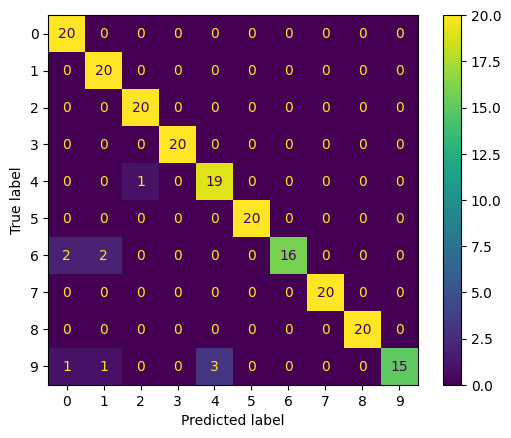

In [24]:
y_pred = np.argmax(y_pred,axis=1)
print(ConfusionMatrixDisplay.from_predictions(labels,y_pred))
print(classification_report(labels,y_pred))

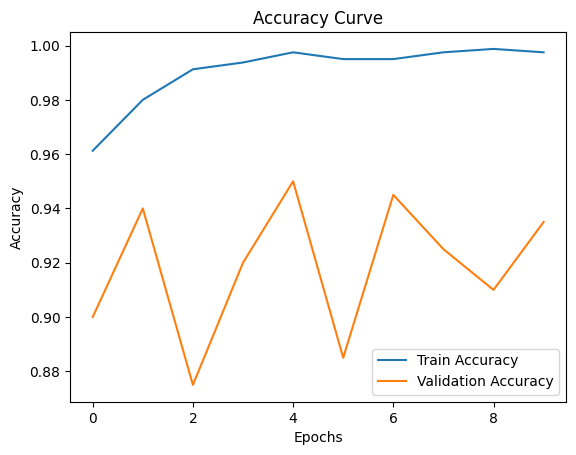

In [48]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

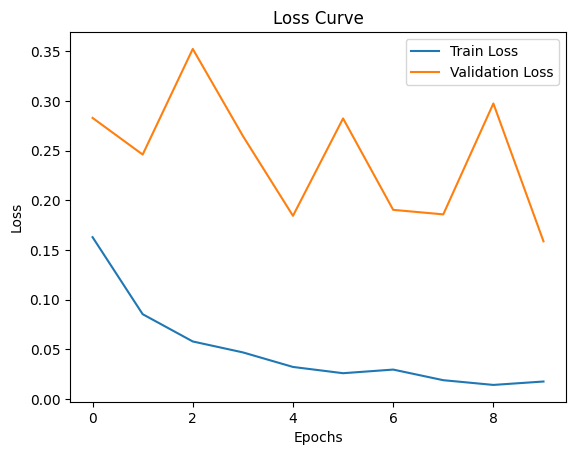

In [49]:
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Prediction on Unseen Data

In [38]:
class_indices = train_set.class_indices
for class_name, encoded_value in class_indices.items():
    print(f"Class '{class_name}' is encoded as: {encoded_value}")

Class '01_palm' is encoded as: 0
Class '02_l' is encoded as: 1
Class '03_fist' is encoded as: 2
Class '04_fist_moved' is encoded as: 3
Class '05_thumb' is encoded as: 4
Class '06_index' is encoded as: 5
Class '07_ok' is encoded as: 6
Class '08_palm_moved' is encoded as: 7
Class '09_c' is encoded as: 8
Class '10_down' is encoded as: 9


In [68]:
class_labels = {
    0: '01_palm',
    1: '02_l',
    2: '03_fist',
    3: '04_fist_moved',
    4: '05_thumb',
    5: '06_index',
    6: '07_ok',
    7: '08_palm_moved',
    8: '09_c',
    9: '10_down'
}
def image_category(image):
  image = cv2.resize(image, (224, 224))
  image = image.reshape(1, 224, 224, 3)
  y_new = model.predict(image)
  predicted_class = y_new.argmax(axis=1)[0]
  predicted_label = class_labels.get(predicted_class)
  print(f"Predicted class: {predicted_label[3:]}")

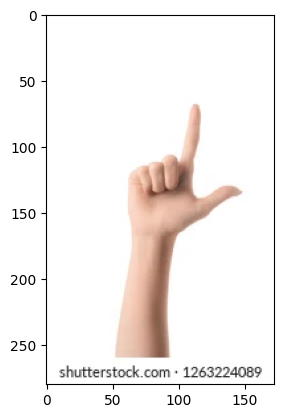

In [69]:
image=cv2.imread('/content/drive/MyDrive/Prodigy Internship Data/Task 4 - Hand Gesture (Unseen data)/L.webp')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [70]:
image_category(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Predicted class: l


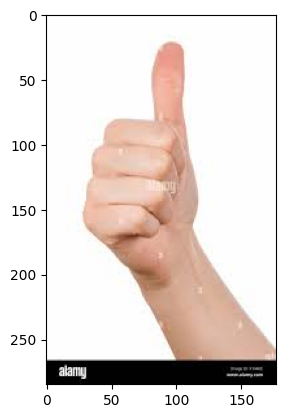

In [79]:
image=cv2.imread('/content/drive/MyDrive/Prodigy Internship Data/Task 4 - Hand Gesture (Unseen data)/Thumb.jpeg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [80]:
image_category(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Predicted class: thumb


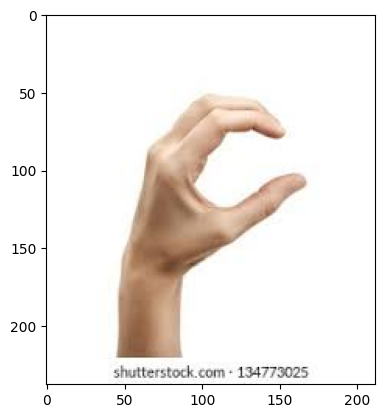

In [81]:
image=cv2.imread('/content/drive/MyDrive/Prodigy Internship Data/Task 4 - Hand Gesture (Unseen data)/C.jpeg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [82]:
image_category(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Predicted class: c
